# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## *(Week 1)*



## Introduction/Business Problem  <a name="introduction"></a>

London is not only the commercial centre of the UK but also attracts millions of visiting tourists every year. This cosmopolitan city has a very vibrant food scene, in that new restaurants are opening all the time but sadly at the same time many restaurants are closing down due to the fierce competition. 

Now, if someone is looking to open a Chinese restaurant in London, can we use data science to help to find out whether a site is good or bad for it? This is the **business problem** I set out to address. The **target audience / stakeholders** are those who plan to open a Chinese restaurant in London, whether as a start-up or a new branch of an existing restaurant, and their investors. In addition, the landlords of the commercial properties in London may also be potential target audience.

One of the past examples of the Capstone project is about recommending where to open an Italian restaurant in Berlin, in which an assumption was that a good spot should be in “areas of Berlin that have low restaurant density, particularly those with low number of Italian restaurants”. This may be a sensible assumption, but on the other hand, observation also tells us that more often restaurants are “clustered” together. For example, I once travelled to Bradford, a small city in northwest England, I was surprised to find 4 French restaurants in the same street of about 300 metres and they all looked quite busy. So the density alone may not be enough to predict whether a location is good or bad for opening a Chinese restaurant - are there any other data/indications we need in order to **make a good prediction**?


## Data <a name="data"></a>

To assess a business case, the well-known SWOT business analysis methodology tells us to look into four aspects, namely, Strengths, Weakness, Opportunities and Threats. As strengths and weakness are internal to the business itself, here we concentrate on the opportunities and threats aspects. 

High restaurant density can represent threats as it means more competition. On the other hand, it can also represent opportunities. For example, a cluster of French restaurants may have some kind of “branding” effect as this may foster a reputation of the area being a go-to place for French cuisines.

The other type of opportunities/threats are represented by the volume and type of  potential customer base the restaurant location has - is it in a high traffic area, i.e. busy and bustling with people, and whether the people are ready to spend money in the restaurant?
A prediction model will therefore needs to take into account of the above ‘features’ of a site in order to predict whether site is a good or bad location for this type of restaurant. 

For this purpose, firstly, the datasets I am going to use to represent restaurant density are:

* For a given location, how many **Chinese restaurants** that are nearby and how close are they to the proposed site for the Chinese restaurant
* For a given location, how many **similar types of restaurants** that are nearby and how close are they to the proposed site for the Chinese restaurant? For similar restaurants, I am referring to Asian types such as Japanese, Korean, Thai, Indian, Malay, etc.
* For a given location, how many **non-similar types of restaurants** are nearby and the proximity of these restaurants to the proposed site.

The above datasets can be obtained by using the **Foursquare API**.

Secondly, for the data about the potential customer base, there is no readily available source. However, I found two data sources that I believe to be good representations of the potential customer base:

1. ATM (i.e. bank automated teller machine) location data. ATMs are installed by banks in locations where there is a high traffic of people who want to withdraw cash. Therefore, the proximity of ATMs can give a good indication of the volume of traffic and the likelihood of people with money to spend. The source of ATM I use for this project is **Overpass API (OpenStreetMap)**.
2. Public Transportation link data. The Underground and buses are two of the major public transportation links within London. **London Underground passenger counts** published by the London Transportation Department can be used as a good indicator of traffic volume.

Finally, we also need the historical data of the prediction target (i.e. how good/bad a location is for a Chinese restaurant) to train and verify the prediction model. Profitability data of existing Chinese restaurants would be the ideal historical data for this purpose but such data are not readily available. Another good representative data is the venue “checkin” statistics from Foursquare, unfortunately, it seems Foursquare does not provide the actual number of checkins (I tested this using Chinese restaurants in London). Therefore, for the purpose of this project, I use the “number of likes” in the **Foursquare venues information**.

To recap, the data I am going to use to train and verify the prediction model are:

* Data for the prediction target: “number of likes” in the **Foursquare venues information**; 
* Data for the features:
  * number of Chinese restaurants nearby and average distance of these restaurants  from the proposed location (**Foursquare API**)
  * number of similar types of restaurants nearby and average distance of these restaurants from the proposed location (**Foursquare API**)
  * number of non-similar types of restaurants nearby and average distance of these restaurants from the proposed location (**Foursquare API**)
  * number of nearby ATMs locations and average distance of the ATMs from the proposed location (**Overpass API -OpenStreetMap**) 
  * **London Underground passenger counts**.


Now, let's start extracting the data and presenting some **examples of the data**.

In [ ]:
###
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import json

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import pickle

from sklearn import linear_model

Firstly, I set out to investigate an area of ~6KM radius of central London. The area of interest can be changed according to stakeholder requirements by adjusting the location of the center point and the length of the radius.

London Chinatown is at the very heart of London right next to the National Gallery, therefore, I choose it as the center point for London.  

In [2]:
###
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = '10 Wardour St, London W1D 6BZ'  # London Chinatown

geolocator = Nominatim(user_agent="me")
location = geolocator.geocode(address)
london_center_lat = location.latitude
london_center_lon = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(london_center_lat, london_center_lon))

The geograpical coordinate of London are 51.5110319, -0.1315618.


Foursquare credentials:

In [3]:
### Will not be shown when sharing


I initially used one Foursquare API call with a radius of 6Km, but it only return 100 restaurants: 

In [4]:
chinese_restaurant_category = '4bf58dd8d48988d145941735'
radius = 6000
limit = 600
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        foursquare_client_id, foursquare_client_secret, foursquare_version, london_center_lat, london_center_lon, chinese_restaurant_category, radius, limit)
results = requests.get(url).json()['response']['groups'][0]['items']
chinese_restaurants = [(item['venue']['id'],
                        item['venue']['name'],
                        (item['venue']['location']['lat'], item['venue']['location']['lng'])) for item in results] 
len(chinese_restaurants)

100

As 150m radius around Chinatown has already nearly 100 restaurants, an area of 6Km radius should have more than 100 restaurants!

**It seems Foursquare API limits the number of venues it returns**. Therefore, I’ll divide the (large) area of interest into smaller ones and make a Foursquare API call for each.


### *\*Acknowledgement\**
*The Python code for dividing the area is very similar to that of the example notebook provided as part of the Capstone assignment. So* ***a massive thanks to the original author of the notebook***. 

*However,* ***the similarity stops here as I’ll be using a complete different inferential statistical method*** *to address a similar business problem.*

In [5]:
###
import pyproj
import math

def latlon_to_xy(lat, lon):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    x, y = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return x, y

def xy_to_latlon(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    lon, lat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lat, lon

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('London center latitude={}, longitude={}'.format(london_center_lat, london_center_lon))
london_center_x, london_center_y = latlon_to_xy(london_center_lat, london_center_lon)
print('Projected London UTM X={}, Y={}'.format(london_center_x, london_center_y))
lat, lon = xy_to_latlon(london_center_x, london_center_y)
print('Projected back London center latitude={}, longitude={}'.format(lat,lon))


Coordinate transformation check
-------------------------------
London center latitude=51.5110319, longitude=-0.1315618
Projected London UTM X=699039.3970373612, Y=5710557.318131826
Projected back London center latitude=51.51103189999999, longitude=-0.1315617999999997


Let's create a **hexagonal grid of cells** of 600m radius: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [6]:
### 
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = london_center_x - 6000
x_step = 600
y_min = london_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 41):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(london_center_x, london_center_y, x, y)
        if (distance_from_center <= 6001):
            lat, lon = xy_to_latlon(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [7]:
import folium
from folium.plugins import HeatMap

london_center=[london_center_lat,london_center_lon]
map_london = folium.Map(location=london_center, zoom_start=12)
folium.Marker(london_center, popup='Chinatown').add_to(map_london)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london) 
    folium.Circle([lat, lon], radius=300, color='yellow', fill=False).add_to(map_london)
    #folium.Marker([lat, lon]).add_to(map_london)
map_london


In [8]:
### 

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, foursquare_version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   (item['venue']['location']['lat'], item['venue']['location']['lng'])) for item in results]       
    except:
        venues = []
    return venues

# get venues information from a list of latitudes and longitudes
def get_venues(lats, lons, cat_id):
    venues = {}
    count = 0
    print('Start', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to make sure we have overlaps/full coverage so we don't miss any restaurant 
        # (we're using dictionaries to remove any duplicates resulting from area overlaps)
        results = get_venues_near_location(lat, lon, cat_id, foursquare_client_id, foursquare_client_secret, radius=350, limit=150)
        for venue in results:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_latlon = venue[2]
            x, y = latlon_to_xy(venue_latlon[0], venue_latlon[1])
            count += 1 
            print(count, end='.')
            venue = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], x, y)                
            venues[venue_id] = venue
        print('.', end='')
    print(' done.')
    return venues

In [9]:
# Get CHINESE restaurants data
# Once the data has been preapre, it will be saved to the hard disc

chinese_restaurants = {}

# Try to load from local file system first in case there is a saved dateset
loaded = False
try:
    with open('chinese_restaurants.pkl', 'rb') as f:
        chinese_restaurants = pickle.load(f)
    print('Chinese restaurant data loaded from local file.')
    loaded = True
except:
    pass

# According to Foursquare web documentation (https://developer.foursquare.com/docs/resources/categories),
# the category for Chinese restaurants include: Chinese Restaurant, Cantonese Restaurant, 
# Cha Chaan Teng, Dim Sum Restaurant, and Szechuan Restaurant. Their IDs are:
chinese_restaurant_categories = ['4bf58dd8d48988d145941735', '52af3a7c3cf9994f4e043bed', '58daa1558bbb0b01f18ec1d3',
                                 '4bf58dd8d48988d1f5931735', '52af3b773cf9994f4e043c03'] 
# If load failed use the Foursquare API to get the data
if not loaded:
    for id in chinese_restaurant_categories:
        chinese_restaurants.update(get_venues(latitudes,longitudes,id))

    # save this in local file system
    with open('chinese_restaurants.pkl', 'wb') as f:
        pickle.dump(chinese_restaurants, f)

print('There are {} Chinese restaurants in the dataset.'.format(len(chinese_restaurants)))

Chinese restaurant data loaded from local file.
There are 369 Chinese restaurants in the dataset.


In [10]:
# Now let's get the number of "likes" for each Chinese restaurant using Foursquare venue API 
# Again, once the data has been preapre, it will be saved to the hard disc

# Try to load from local file system first in case there is a saved dateset
loaded = False
try:
    with open('chinese_restaurants_with_likes.pkl', 'rb') as f:
        chinese_restaurants_with_likes = pickle.load(f)
    print('Chinese restaurant data loaded from local file.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    chinese_restaurants_with_likes = {}
    result_jsons = []
    for venue_id in list(chinese_restaurants):
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, foursquare_client_id, foursquare_client_secret, foursquare_version)
        results = requests.get(url).json()
        likes = results['response']['venue']['likes']['count']
        result_jsons.append(results)
        chinese_restaurants_with_likes[venue_id] = chinese_restaurants[venue_id]+(likes,)

    # save this in local file system
    with open('chinese_restaurants_with_likes.pkl', 'wb') as f:
        pickle.dump(chinese_restaurants_with_likes, f)

len(chinese_restaurants_with_likes)

Chinese restaurant data loaded from local file.


369

In [11]:
# Get data of similar types of restaurants
# Once the data has been preapre, it will be saved to the hard disc

similar_restaurants = {}

# Try to load from local file system first in case there is a saved dateset
loaded = False
try:
    with open('similar_restaurants.pkl', 'rb') as f:
        similar_restaurants = pickle.load(f)
    print('Similar restaurant data loaded from local file.')
    loaded = True
except:
    pass

# Restaurant categories that are similar to Chinese mainly include: Indonesian, Japanese, Korean Restaurant, Malay,  
# Thai, Vietnamese,Indian, Pakistani, and Sri Lankan Restaurants. According to Foursquare web documentation
# (https://developer.foursquare.com/docs/resources/categories), their IDs are:
similar_restaurant_categories = ['4deefc054765f83613cdba6f','4bf58dd8d48988d111941735','4bf58dd8d48988d113941735',
                                 '4bf58dd8d48988d156941735','4bf58dd8d48988d149941735','4bf58dd8d48988d14a941735',
                                 '4bf58dd8d48988d10f941735','52e81612bcbc57f1066b79f8','5413605de4b0ae91d18581a9']
# If load failed use the Foursquare API to get the data
if not loaded:
    for id in similar_restaurant_categories:
        similar_restaurants.update(get_venues(latitudes,longitudes,id))

    # save this in local file system
    with open('similar_restaurants.pkl', 'wb') as f:
        pickle.dump(similar_restaurants, f)

print('There are {} similar restaurants in the dataset.'.format(len(similar_restaurants)))

Similar restaurant data loaded from local file.
There are 1608 similar restaurants in the dataset.


In [12]:
# Get data of non-similar types of restaurants
# Once the data has been preapre, it will be saved to the hard disc

non_similar_restaurants = {}

# Try to load from local file system first in case there is a saved dateset
loaded = False
try:
    with open('non_similar_restaurants.pkl', 'rb') as f:
        non_similar_restaurants = pickle.load(f)
    print('Non-similar restaurant data loaded from local file.')
    loaded = True
except:
    pass

# Restaurant categories that are not similar to Chinese mainly include: American, Caribbean, Eastern European, English, French, 
# German, Greek, Italian, Jewish, Latin American, Mexican, Middle Eastern, Modern European, Russian, Spanish, and Turkish Restaurants.
# According to Foursquare web documentation # (https://developer.foursquare.com/docs/resources/categories), their IDs are:
non_similar_restaurant_categories = ['4bf58dd8d48988d14e941735','4bf58dd8d48988d144941735','4bf58dd8d48988d109941735',
                                     '52e81612bcbc57f1066b7a05','4bf58dd8d48988d10c941735','4bf58dd8d48988d10d941735',
                                     '4bf58dd8d48988d10e941735','4bf58dd8d48988d110941735','52e81612bcbc57f1066b79fd',
                                     '4bf58dd8d48988d1be941735','4bf58dd8d48988d1c1941735','4bf58dd8d48988d115941735',
                                     '52e81612bcbc57f1066b79f9','5293a7563cf9994f4e043a44','4bf58dd8d48988d150941735',
                                     '4f04af1f2fb6e1c99f3db0bb']
# If load failed use the Foursquare API to get the data
if not loaded:
    for id in non_similar_restaurant_categories:
        non_similar_restaurants.update(get_venues(latitudes,longitudes,id))

    # save this in local file system
    with open('non_similar_restaurants.pkl', 'wb') as f:
        pickle.dump(non_similar_restaurants, f)

print('There are {} non-similar restaurants in the dataset.'.format(len(non_similar_restaurants)))

Non-similar restaurant data loaded from local file.
There are 4065 non-similar restaurants in the dataset.


In [13]:
# Use Overpass API (Open Street Map) to obtain ATM locations

radius=6150
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_atm_query = """
[out:json][timeout:180];
node[amenity=atm](around:{},{},{});
out;
""".format(radius,london_center[0],london_center[1])
response = requests.get(overpass_url, params={'data': overpass_atm_query})
atm_data = response.json()
atm_latlons = [[item['lat'],item['lon']] for item in atm_data['elements']]
atm_xy = [latlon_to_xy(atm_latlon[0],atm_latlon[1]) for atm_latlon in atm_latlons]

In [14]:
# Chinese restaurant heatmap overlaid with ATM

chinese_restaurant_latlons = [(res[2],res[3]) for res in chinese_restaurants.values()]
map_london = folium.Map(london_center, zoom_start=12)
# folium.Marker(london_center, popup='Chinatown').add_to(map_london)
folium.CircleMarker(london_center, radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_london) 
HeatMap(chinese_restaurant_latlons,radius=10).add_to(map_london)
for latlon in atm_latlons:
   folium.CircleMarker(latlon, radius=1, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london) 
    
map_london

### Examples of the data
Following are the some **examples of the data**:

In [15]:
print('Examples of Chinese restaurants')
print('-------------------------------')
for r in list(chinese_restaurants_with_likes.values())[:10]:
    print(r)
print('...')
print('Total:', len(chinese_restaurants_with_likes))

Examples of Chinese restaurants
-------------------------------
('51be1a81498e7e9475a2847c', 'Mama Lan', 51.46158222955795, -0.1386893677680702, 698759.924395796, 5705040.036369441, 47)
('57433804498e6896a9ac6c3d', 'On Cafe', 51.461159936690485, -0.13606309890747068, 698944.1605157366, 5705000.219283052, 8)
('4fa44009e4b0cfe54c0e2cfb', 'Courtesan Dim Sum', 51.46115994755113, -0.11122012921135563, 700669.5588322084, 5705068.029273553, 45)
('4c0e9eb87189c92802ccd8b6', 'Big Fat Panda', 51.46406135523888, -0.16523420365737124, 696905.6586762026, 5705243.931458072, 5)
('4c93c6e458d4b60c7f6f2229', 'Ku Do', 51.465477250000006, -0.127758, 699502.1307681849, 5705502.82779718, 0)
('4bf4369dff90c9b687fa5428', 'Sun', 51.463309237975686, -0.13375971722526808, 699094.777378501, 5705245.444308283, 1)
('5543caad498ed0aa60d91ec9', 'Fu Manchu', 51.46450966067314, -0.12982931791815347, 699362.5056508451, 5705389.606454721, 29)
('4e7dccf5d3e3294a67ba2f07', 'Mama Lan', 51.462523456612985, -0.11227912704606

In [16]:
print('Examples of similar restaurants')
print('-------------------------------')
for r in list(similar_restaurants.values())[:10]:
    print(r)
print('...')
print('Total:', len(similar_restaurants))

Examples of similar restaurants
-------------------------------
('4b4cd41bf964a5208dc026e3', "Nancy Lam's Enak Enak", 51.465976, -0.153701, 697698.3406066891, 5705487.89209157)
('5a8058b99de23b09d875b87e', 'Warung Rumpi London', 51.488782, -0.092265, 701863.9928464844, 5708191.203633217)
('5ad9e177a92d981f70847a1c', 'Sambel', 51.501529, -0.111248, 700490.4209270055, 5709556.237222514)
('55eb0642498e36ccf4d34004', 'Japindo', 51.49874093205115, -0.06749286354492272, 703539.0299959745, 5709367.073062456)
('548cc33d498e7cd8fda0e079', 'Soda Coda Cafe', 51.498748779296875, -0.06757054477930069, 703533.6043903355, 5709367.729417515)
('4e4a70b4d4c0dae7bfcb7fc0', 'Banana Tree', 51.51312243247239, -0.13374866254940396, 698878.5714444991, 5710783.800307268)
('4ac518dcf964a52023a920e3', 'Bali Bali', 51.51385268807065, -0.12840184944050295, 699246.3092473993, 5710879.5419694455)
('561007a5498e8b545895df6a', 'Nusa Dua', 51.51259012437537, -0.13079917077626516, 699085.5090451674, 5710732.640214789)
(

In [17]:
print('Examples of non-similar restaurants')
print('-----------------------------------')
for r in list(non_similar_restaurants.values())[10:19]:
    print(r)
print('...')
print('Total:', len(non_similar_restaurants))

Examples of non-similar restaurants
-----------------------------------
('4d02a1c7e350b60c291b7842', 'Venn Street Records', 51.4623889239294, -0.1378505864819057, 698814.6717795614, 5705132.003742321)
('57fcc1d7498e78978286c511', 'Phase Four', 51.46534239225995, -0.12877569412468998, 699432.0445504743, 5705485.0608908115)
('53444abe498eba6f0db62b87', 'Red Dog Saloon', 51.46445481434657, -0.12926999840357697, 699401.5879960831, 5705385.0320397625)
('4ec2bcbb8231a83de8c751f7', 'Chicken & ribs', 51.46594512202947, -0.11445495837103714, 700423.9171643042, 5705591.187734496)
('532c9031498e13befbe4469e', 'Brixton Diner', 51.46288842728365, -0.10830529972110091, 700864.4065985312, 5705268.197783859)
('56deb685cd10bb2f76fdc1f3', 'Hip Hop Chip Shop', 51.461915912148626, -0.11195728013338438, 700615.0456041377, 5705150.057719219)
('4c7384e38efc3704b9ca157d', 'Love Walk Cafe', 51.47086901877433, -0.09286352926981543, 701901.5784266564, 5706197.9714792315)
('4d3b0ba6039eb60c0157f19c', 'The Old Dis

In [18]:
print('Examples of ATM data')
print('--------------------')
for r in atm_latlons[0:9]:
    print(r)
print('...')
print('Total:', len(atm_latlons))

Examples of ATM data
--------------------
[51.5168043, -0.1041936]
[51.5337252, -0.2044338]
[51.5441105, -0.0899055]
[51.5434742, -0.0908125]
[51.5298413, -0.0803599]
[51.528965, -0.0776711]
[51.530544, -0.0789771]
[51.5177608, -0.1092027]
[51.5144211, -0.0567841]
...
Total: 537


Note: The London Underground passenger counts has also been downloaded as an Excel file (*multi-year-station-entry-and-exit-figures2017.xlsx*) to be used in the next phase of this project.

## *(Week 2)*

## Further Preparation of Datasets and Explanatory Analysis

Let's look at the restaurant density. Firstly, let's find out, within 150 meters of each Chinese restaurant, how many other Chinese retaurants are there and what is the average distance of these restaurants.

In [19]:
# Loading London Metro station data
# Once the data has been prepared, it will be save into hard disk as an Excel file

# First, try to load from hard disc to see if there is a saved copy of the dataset
try:
    metro_passengers_df = pd.read_excel('metro_passengers_df.xlsx')
    
except:
    metro_df=pd.read_excel('multi-year-station-entry-and-exit-figures2017.xlsx', sheet_name=1, header=6)
    metro_df=metro_df.head(268) # exclude the last 2 rows, which are for "Total" 
    
    # get station latitude and Longitude using geocoder, showing any stations that could not be found
    metro_station_latlons = []
    count = 0
    print('Start',end='')
    for row in metro_df.values:
        address = row[1] +' Station, London' 
        location = geolocator.geocode(address)
        if location == None: # any missing data, print 
            metro_station_latlons.append([])
            print(count,row[1],end='. ')
        else:
            metro_station_latlons.append([location.latitude,location.longitude])
            print('.',end='')
        count += 1
    print('done',end='')
    
    # Fix any missing data, source: https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations
    metro_station_latlons[40] = [51.66822,-0.56053] # For Chalfont & Latimer
    metro_station_latlons[55] = [51.64733268,-0.441479115] # for Croxley
    metro_station_latlons[148] = [51.62970512,-0.432070848] # for Moor Park
    
    metro_xy = [latlon_to_xy(metro_latlon[0],metro_latlon[1]) for metro_latlon in metro_station_latlons]
    metro_passengers_df = pd.DataFrame(metro_xy, columns=['X','Y'])
    metro_passengers_df = metro_passengers_df.join(metro_df['million']) 
    metro_passengers_df = metro_passengers_df.join(pd.DataFrame(metro_station_latlons, columns=['Latitude','Longitude']))
    metro_passengers_df.to_excel('metro_passengers_df.xlsx',index=False)

print('Metro passenger date loaded')


Metro passenger date loaded


In [20]:
def nearby_venue_count_dist(venue1, venues, radius=150):
    x1 = venue1[4]
    y1 = venue1[5]
    venues_found = []
    for venue in list(venues.values()):
        if venue[0] != venue1[0]: # do not include itself
            x = venue[4]
            y = venue[5] 
            distance = calc_xy_distance(x1, y1, x, y)
            if distance < radius:
                venues_found.append(distance)
    count = len(venues_found)
    avg_d = 0
    if count > 0:
        avg_d = sum(venues_found)/count
    return count, avg_d

In [21]:
dataset=[]
for c_res in list(chinese_restaurants_with_likes.values()):
    # For each Chinese restauran, find out the number of nearby Chinese restaurants, similar types of restaurants and 
    # non-similar types type of restaurants and their average distances to that particular Chinese restaurant 
    c_res = c_res+ nearby_venue_count_dist(c_res,chinese_restaurants_with_likes,150) + \
            nearby_venue_count_dist(c_res,similar_restaurants,150) + \
            nearby_venue_count_dist(c_res,non_similar_restaurants,150)
    
    x1 = c_res[4] #Chinese restaurant coordinate X
    y1 = c_res[5] #Chinese restaurant coordinate Y
    
    # Nearby ATM count and average distance 
    radius = 100
    count = 0
    ATM_found = []
    for x,y in atm_xy:
        distance = calc_xy_distance(x1, y1, x, y)
        if distance < radius:
            ATM_found.append(distance)
    count = len(ATM_found)
    avg_d = 0
    if count > 0:
        avg_d = sum(ATM_found)/count
        
    # Nearby Metro passager annual traffic in millions, weighted by distance 
    radius = 250
    passengers = 0  
    for value in metro_passengers_df.values:
        x = value[0] #Metro station coordinate X
        y = value[1]
        distance = calc_xy_distance(x1, y1, x, y)
        if distance < radius:
            passengers += value[2] * (1- distance/radius)
        
    dataset.append(c_res + (count,avg_d,passengers))

column_names = ['ID','Name','Latitude','Lontitude','X','Y','Likes','C Count','C Avg Distance',
                'S Count','S Avg Distance','N Count','N Avg Distance','ATM Count','ATM Avg Distance','Metro Passengers in million']
                #'Metro Avg Distance','Metro Passenger Weekday','Metro Passenger Weekend']
chinese_df = pd.DataFrame(dataset,columns = column_names)
chinese_df.head()

,ID,Name,Latitude,Lontitude,X,Y,Likes,C Count,C Avg Distance,S Count,S Avg Distance,N Count,N Avg Distance,ATM Count,ATM Avg Distance,Metro Passengers in million
0,51be1a81498e7e9475a2847c,Mama Lan,51.461582,-0.138689,698759.924396,5.705040e+06,47,0,0.000000,4,100.132016,15,90.317081,2,41.540063,4.600427
1,57433804498e6896a9ac6c3d,On Cafe,51.461160,-0.136063,698944.160516,5.705000e+06,8,0,0.000000,1,129.779787,7,130.101956,1,9.079123,0.000000
2,4fa44009e4b0cfe54c0e2cfb,Courtesan Dim Sum,51.461160,-0.111220,700669.558832,5.705068e+06,45,1,132.150789,3,84.929448,7,119.426002,0,0.000000,0.000000
3,4c0e9eb87189c92802ccd8b6,Big Fat Panda,51.464061,-0.165234,696905.658676,5.705244e+06,5,0,0.000000,0,0.000000,3,60.807068,1,58.927184,0.000000
4,4c93c6e458d4b60c7f6f2229,Ku Do,51.465477,-0.127758,699502.130768,5.705503e+06,0,0,0.000000,1,148.460659,5,88.266078,0,0.000000,2.833457


Now, we have finished preparing our dataset.

### Descriptive Statistics

Let's first have a look at the descriptive statistics of on our data:

In [22]:
chinese_df[['Likes','C Count','S Count','N Count','ATM Count','Metro Passengers in million']].describe()

,Likes,C Count,S Count,N Count,ATM Count,Metro Passengers in million
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,72.810298,10.737127,9.878049,15.905149,0.615176,4.658470
std,190.129152,20.385517,11.825212,14.102659,0.948905,8.380868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.000000,5.000000,0.000000,0.000000
50%,15.000000,1.000000,5.000000,11.000000,0.000000,0.000000
75%,65.000000,4.000000,12.000000,26.000000,1.000000,6.589856
max,2183.000000,66.000000,42.000000,63.000000,4.000000,63.376332


In [23]:
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

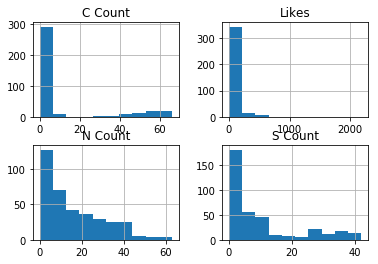

In [24]:
viz = chinese_df[['Likes','C Count','S Count','N Count']]
viz.hist()
plt.show()

In [25]:
print('No of Chinese restaurants with 10 or less Likes:', (chinese_df['Likes'] <= 10).sum())

No of Chinese restaurants with 10 or less Likes: 164


Here, we can have a few observations: 
* Large number of Chinese restaurants have 0 - 5 other Chinese restaurants nearby, and there are a number of Chinese restaurants have 40 - 60 other Chinese restaurants nearby. On the other hand, there are very few Chinese restaurants have 10 - 40 other Chinese restaurants nearby. That is, in London, Chinese restaurants exist among either very low or very high density of other Chinese restaurants, but not mid-density;
* Interestingly, a similar phenomenon can be observed for nearby similar type of restaurants, i.e. in London, Chinese restaurants exist among either very low or very high density of other similar type of restaurants, but not mid-density (as mentioned previously, similar type of restaurants refer to Japanese, Korean, Malay, Thai, Vietnamese, etc);
* There are large number of Chinese restaurants has very low number of Likes, in fact, there are 164 Chinese restaurants has 10 or less Likes. These is rather alarming as I am going to use the number of Likes as an indicator of how well a restaurant is doing. However, for large number of restaurants serving hundreds of customers, such low number of Likes it looks to me is because Fourquare is not popular amount London Chinese restaurant customer, hence, **may not be used as a reliable indicator**.

Now, lets plot each of these features vs the number of Likes, to further explore how it relate to other features:

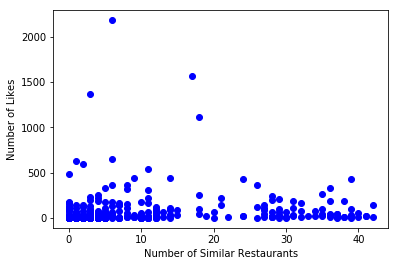

In [26]:
plt.scatter(chinese_df['S Count'], chinese_df['Likes'],  color='blue')
plt.xlabel("Number of Similar Restaurants")
plt.ylabel("Number of Likes")
plt.show()

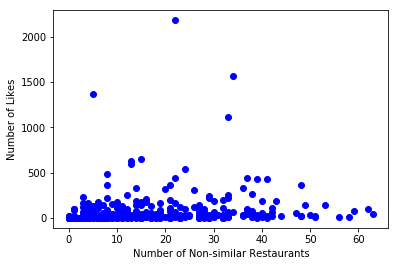

In [27]:
plt.scatter(chinese_df['N Count'], chinese_df['Likes'],  color='blue')
plt.xlabel("Number of Non-similar Restaurants")
plt.ylabel("Number of Likes")
plt.show()

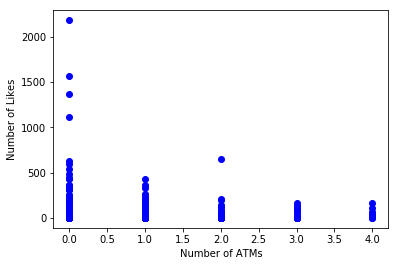

In [28]:
plt.scatter(chinese_df['ATM Count'], chinese_df['Likes'],  color='blue')
plt.xlabel("Number of ATMs")
plt.ylabel("Number of Likes")
plt.show()

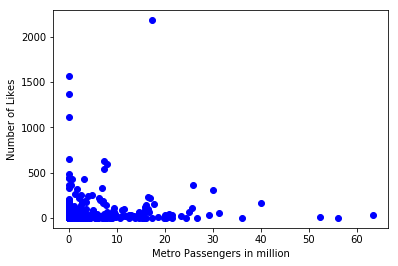

In [29]:
plt.scatter(chinese_df['Metro Passengers in million'], chinese_df['Likes'],  color='blue')
plt.xlabel("Metro Passengers in million")
plt.ylabel("Number of Likes")
plt.show()

No obvious patern is found from the plots. Now, let's try to fit all features in multiple linear regression model:

In [30]:
msk = np.random.rand(len(chinese_df)) < 0.8
train = chinese_df[msk]
test = chinese_df[~msk]

regr = linear_model.LinearRegression()
x = np.asanyarray(train[['C Count','C Avg Distance','S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(train[['Likes']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

y_hat= regr.predict(test[['C Count','C Avg Distance','S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
x = np.asanyarray(test[['C Count','C Avg Distance','S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(test[['Likes']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[ -1.90612253   0.22167856   1.21200672   0.14818255   2.28451487
    0.21501413 -10.97777827  -0.22530643   0.74525591]]
Intercept:  [10.01547311]
Residual sum of squares: 24202.07
Variance score: 0.16


**The variance score is so low, it is obvious the model cannot provide any reliable prediction.**

Now, back to the drawing board: 

Firstly, let's look at the **business problem and the stakeholders** : in essence, I want to help stakeholder to find out whether a site is suitable for opening a Chinese restaurant.

Secondly, it is found that the Likes data from Foursquare is not a good indication of how well a restaurant is doing. Foursuqare data does include number of checkins, which may be a good indication of how popular a restaurant is, however, Foursuqare only offer such data to "authorise" users such as the owner of the the establishment. 

Finally, let's look at what we have so far:
* We found some pattern in the "desity" of nearby Chinese restaurants and similar type of restaurants.
* From the heatmap, we also found the Chinese restaurants seem to follow the distribution of the ATM locations.

Therefore, we can try to predict the "density" of nearby Chinese restaurants using the dataset we have got. If our model can make a good prediction, we can still help the stakeholders. It is because for a given location, we can actually use the model to predict how many nearby Chinese restaurants should have for that location. If in reality there are less nearby Chinese restaurants, we can say there is a good chance the area can "sustain" a new Chinese restaurant!


Let's now make *"the Number of Nearby Chinese restaurants"* as the dependent variable, and plot each of the other features against it:


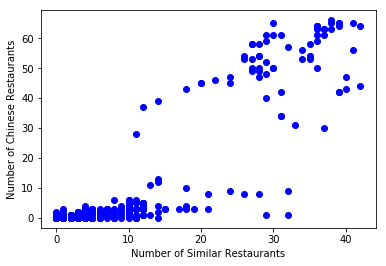

In [31]:
plt.scatter(chinese_df['S Count'], chinese_df['C Count'],  color='blue')
plt.xlabel("Number of Similar Restaurants")
plt.ylabel("Number of Chinese Restaurants")
plt.show()

We can see some linearity in this plot!

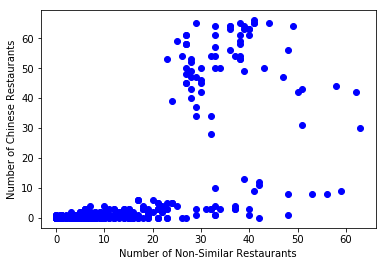

In [32]:
plt.scatter(chinese_df['N Count'], chinese_df['C Count'],  color='blue')
plt.xlabel("Number of Non-Similar Restaurants")
plt.ylabel("Number of Chinese Restaurants")
plt.show()

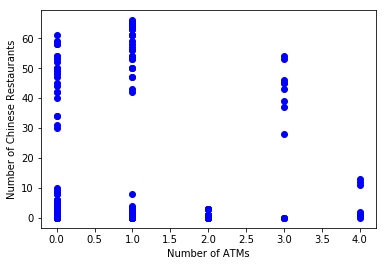

In [33]:
plt.scatter(chinese_df['ATM Count'], chinese_df['C Count'],  color='blue')
plt.xlabel("Number of ATMs")
plt.ylabel("Number of Chinese Restaurants")
plt.show()

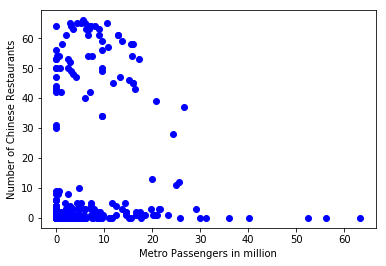

In [34]:
plt.scatter(chinese_df['Metro Passengers in million'], chinese_df['C Count'],  color='blue')
plt.xlabel("Metro Passengers in million")
plt.ylabel("Number of Chinese Restaurants")
plt.show()

From these plots, we can see Chinese restaurants exist in either low density or high density but nothing in-between.

Now, let's try to fit dataset to a multiple linear regression model again but this time the dependent variable is *"the Number of Nearby Chinese restaurants"*, and randomly selected 80% of the dataset is used for training the model while the remaining 20% for testing:

In [50]:
msk = np.random.rand(len(chinese_df)) < 0.8
train = chinese_df[msk]
test = chinese_df[~msk]

regr = linear_model.LinearRegression()
x = np.asanyarray(train[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(train[['C Count']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

y_hat= regr.predict(test[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
x = np.asanyarray(test[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(test[['C Count']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[ 2.04582649 -0.04136192 -0.50774304  0.05310833 -1.1178604   0.02278035
   0.14591741]]
Intercept:  [-3.54311936]
Residual sum of squares: 55.05
Variance score: 0.87


The resulting model was then tested with remaining 20% of the dataset, the **variance score** of the resulting model is **0.87**, which is **very close to a perfect prediction (score of 1)**, it means the model can provide a very good prediction. Therefore, a multiple linear regression model is used as the predictive model for addressing our business problem.

Now, **100%** of the dataset is used to derived a multiple linear regression model:

In [51]:
regr = linear_model.LinearRegression()
x = np.asanyarray(chinese_df[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(chinese_df[['C Count']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

y_hat= regr.predict(chinese_df[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
x = np.asanyarray(chinese_df[['S Count','S Avg Distance','N Count','N Avg Distance',
                         'ATM Count','ATM Avg Distance','Metro Passengers in million']])
y = np.asanyarray(chinese_df[['C Count']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[ 2.11546858 -0.03974706 -0.57464468  0.05390643 -0.64187237  0.01702939
   0.18028619]]
Intercept:  [-3.53078879]
Residual sum of squares: 62.07
Variance score: 0.85


The variance score is very close to 1, i.e. this model can offer a very good prediction!

Let's have a look at some examples. I've selected a few addresses and assume these are the sites to be consider to open a new Chinese restaurant:
1. 119 Newington Causeway, Elephant and Castle, London SE1 6BN
2. 160 Old Street, London EC1V 9FR
3. 276 Kentish Town Rd, London NW5 2AA

Then using Foursquare API to find out how many Chinese are nearby to the candidate sites and how many are predicted using the multiple linear regression model just developed.


In [81]:
# address of the new site under consideration
address = '276 Kentish Town Rd, London NW5 2AA'  

geolocator = Nominatim(user_agent="me")
location = geolocator.geocode(address)
new_site_lat = location.latitude
new_site_lon = location.longitude
print('The geograpical coordinate of the new site under considerationare {}, {}.'.format(new_site_lat, new_site_lon))

The geograpical coordinate of the new site under considerationare 51.5503691, -0.1405158.


In [ ]:
# Gathering data nearby restaurants
new_site_x, new_site_y = latlon_to_xy(new_site_lat, new_site_lon)
new_site = [0,0,0,0,new_site_x,new_site_y] # for passing the new site coordinate date into the nearby_venue_count_dist function  

new_site_chinese_restaurants = {}
for id in chinese_restaurant_categories:
    new_site_chinese_restaurants.update(get_venues([new_site_lat], [new_site_lon],id))
c_count,c_dist = nearby_venue_count_dist(new_site,new_site_chinese_restaurants,150)  

new_site_similar_restaurants = {}
for id in similar_restaurant_categories:
    new_site_similar_restaurants.update(get_venues([new_site_lat], [new_site_lon],id))
s_count,s_dist = nearby_venue_count_dist(new_site,new_site_similar_restaurants,150)  

new_site_non_similar_restaurants = {}
for id in non_similar_restaurant_categories:
    new_site_non_similar_restaurants.update(get_venues([new_site_lat], [new_site_lon],id))
n_count,n_dist = nearby_venue_count_dist(new_site,new_site_non_similar_restaurants,150)  


In [83]:
# Nearby ATM count and average distance 
radius = 100
atm_count = 0
ATM_found = []
for x,y in atm_xy:
    distance = calc_xy_distance(new_site_x, new_site_y, x, y)
    if distance < radius:
        ATM_found.append(distance)
atm_count = len(ATM_found)
atm_avg_d = 0
if atm_count > 0:
    atm_avg_d = sum(ATM_found)/atm_count
    
# Nearby Metro passager annual traffic in millions, weighted by distance 
radius = 250
passengers = 0  
for value in metro_passengers_df.values:
    x = value[0] #Metro station coordinate X
    y = value[1]
    distance = calc_xy_distance(new_site_x, new_site_y, x, y)
    if distance < radius:
        passengers += value[2] * (1- distance/radius)

print('Number of nearby Chinese restaurants: {}, avg distance {}:'.format(c_count,c_dist))
print('Number of nearby similar restaurants: {}, avg distance {}:'.format(s_count,s_dist))
print('Number of nearby non-similar restaurants: {}, avg distance {}:'.format(n_count,n_dist))
print('New site nearby ATMs: {}, Avg distance: {}'.format(atm_count, atm_avg_d))
print('New site nearby Metro annual passenger: {} million'.format(passengers))

Number of nearby Chinese restaurants: 0, avg distance 0:
Number of nearby similar restaurants: 2, avg distance 22.22882342280836:
Number of nearby non-similar restaurants: 11, avg distance 75.69019366046498:
New site nearby ATMs: 2, Avg distance: 60.6270535634317
New site nearby Metro annual passenger: 4.497730544088462 million


In [84]:
c = regr.coef_[0]
y_hat = c[0]*s_count + c[1]*s_dist + c[2]*n_count + c[3]*n_dist + c[4]*atm_count + c[5]*atm_avg_d + c[6]*passengers + regr.intercept_[0]
y_hat

-1.864709056785713

Here are the results:

1. For “119 Newington Causeway, Elephant and Castle, London SE1 6BN” - currently 0 Chinese restaurant nearby, predicted 1.74. This can be interpreted as the location may be a suitable site for opening a new Chinese restaurant.
2. For “160 Old Street, London EC1V 9FR” - currently 2 Chinese restaurants nearby, predicted 1.66. The actual number of nearby Chinese restaurant is the similar to the predicted number, which could mean the site may still be suitable for opening a new Chinese restaurant but any more new  openings in the future could tip the balance into negative side.
3. For “276 Kentish Town Rd, London NW5 2AA” - currently 0 Chinese restaurant, predicted -1.86. This can be interpreted as the location may not be a suitable site for opening a new Chinese restaurant.

